# Movie Ratings Network

This notebook is used to create the movie networks based on the ratings. It use the same approach as suggested in [[1](https://arxiv.org/pdf/1408.1717.pdf)]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = '../data/ml-100k-convert/'
GENERATED_PATH = '../generated/'
RESULT_PATH = '../results/'

In [2]:
# Load data
ratings = pd.read_csv(DATA_PATH+'data.tsv', sep='\t', names=['UserId', 'MovieId', 'Ratings', 'Timestamp'])
print(ratings.shape)
ratings.head()

(100000, 4)


,UserId,MovieId,Ratings,Timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
# Load the movie id
movies = pd.read_csv(GENERATED_PATH+'final_movies.csv')
movies_id = movies['ML-100k-convertId'].to_list()

In [4]:
ratings = ratings[ratings.MovieId.isin(movies_id)]
ratings

,UserId,MovieId,Ratings,Timestamp
1,186,302,3,891717742
3,244,51,2,880606923
4,166,346,1,886397596
6,115,265,2,881171488
8,305,451,3,886324817
...,...,...,...,...
99991,676,538,4,892685437
99992,721,262,3,877137285
99995,880,476,3,880175444
99996,716,204,5,879795543


In [5]:
nb_users = len(ratings.UserId.unique())
nb_movies = len(ratings.MovieId.unique())
print('There are {} users'.format(nb_users))
print('There are {} movies'.format(nb_movies))

There are 943 users
There are 480 movies


In [6]:
# Get rid of timestamp
ratings = ratings.drop(columns=['Timestamp'])
# Pivot the table, put 0 when there are no ratings
ratings = pd.pivot_table(ratings, index='UserId', columns='MovieId', values='Ratings', fill_value=0)
ratings

MovieId,1,2,3,4,5,8,9,10,11,12,...,1514,1525,1526,1530,1547,1615,1651,1654,1664,1680
UserId,,,,,,,,,,,,,,,,,,,,,
1,5,3,4,3,3,1,5,3,2,5,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,4,0,...,0,0,0,0,0,0,0,0,0,0
5,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0,0,0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
940,0,0,0,2,0,5,3,0,0,4,...,0,0,0,0,0,0,0,0,0,0
941,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
counts = ratings[ratings > 0].count(axis=1)
print("User with the smallest number of ratings :", counts.min())
print("User with the most ratings :", counts.max())
print("Average number of ratings per user:", counts.mean())

User with the smallest number of ratings : 4
User with the most ratings : 304
Average number of ratings per user: 62.79745493107105


## Distance between movie

To compute the distance between two movies we look at all ratings they gets from the same people. We compute then the L2 norm of the difference of ratings for the movies by the same user and normalize it by the square root of the number of users who rated both movies. We use it as a distance between the movies.


$$
d_{m_{i j}}=\frac{\left\|\left[F_{m_{i}}-F_{m_{j}}\right]_{\Omega_{m_{i j}}}\right\|_{\ell_{2}}}{ \sqrt{\left|\Omega_{m_{i j}}\right|}}
$$


where $\Omega_{m_{i j}}=\Omega_{m_{i}} \cap \Omega_{m_{j}}$ is the set of user who rated both movie.

Note: we do not have to consider the bias introduced by the user as we compute the difference between gradings coming from the same users.

In [118]:
def movie_distance(ratingsA, ratingsB):
    diff_ratings = []
    for x, y in zip(ratingsA, ratingsB):
        if x != 0 and y != 0:
            diff_ratings.append(x - y)
    if len(diff_ratings) > 1:
        return np.linalg.norm(diff_ratings, 2)/np.sqrt(len(diff_ratings))
    else:
        return np.inf

In [119]:
distance_matrix = np.ndarray(shape=(nb_movies, nb_movies))

In [120]:
for i, idx in enumerate(ratings.columns):
    for j, idy in enumerate(ratings.columns):
        distance_matrix[i, j] = movie_distance(ratings[idx].to_list(), ratings[idy].to_list())
        distance_matrix[j, i] = distance_matrix[i, j]

In [121]:
len(distance_matrix[distance_matrix == 0])

1619

## Adjacency matrix

To compute the adjacency matrix from the distance matrix we use a Gaussian kernel which is :

$$
w_{ij} = \text{exp}\left[ - \frac{d_{ij}^2}{\alpha} \right]
$$

if $d_{ij} < \epsilon$ and 0 otherwise.

Here we choose $\epsilon = 1.1$ and $\alpha$ to get a weigth already near to zero when $d_{ij} \rightarrow \epsilon$ as shown in the graph below 

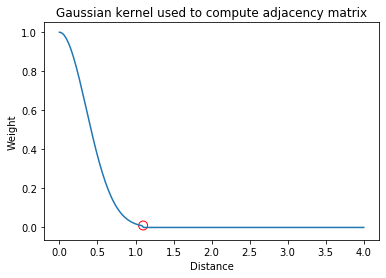

In [122]:
dist = np.linspace(0, 4, 200)
alpha = 0.25
epsilon = 1.1
weight = np.exp(- dist ** 2 / alpha)
weight[dist > epsilon] = 0

plt.figure()
plt.plot(dist, weight)
plt.scatter(epsilon, 0.01, s=80, facecolors='none', edgecolors='r')
plt.title("Gaussian kernel used to compute adjacency matrix")
plt.xlabel("Distance")
plt.ylabel("Weight")
plt.savefig(RESULT_PATH+'gaussian_kernel.eps')
plt.show()

In [123]:
def epsilon_similarity_graph(distances: np.ndarray, alpha=1, epsilon=0):
    """ X (n x n): distance matrix
        alpha (float): width of the kernel
        epsilon (float): threshold
        Return:
        adjacency (n x n ndarray): adjacency matrix of the graph.
    """
    X = distances.copy()
    X[X > epsilon] = np.inf
    adjacency = np.exp( - X ** 2 / alpha)
    np.fill_diagonal(adjacency, 0)
    return adjacency

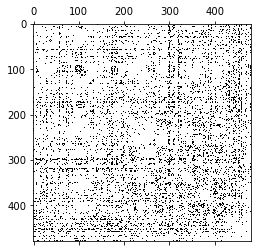

In [124]:
adjacency = epsilon_similarity_graph(distance_matrix, alpha=alpha, epsilon=epsilon)
plt.spy(adjacency)
plt.show()

In [125]:
np.savetxt(GENERATED_PATH+'movie_ratings_adj.csv', adjacency, delimiter=',')

In [63]:
ratings.to_csv(GENERATED_PATH+'ratings_matrix.csv')

In [17]:
import networkx as nx

graph = nx.from_numpy_array(adjacency)
nx.write_gexf(graph, RESULT_PATH+'gexf/movie_ratings.gexf')